# Import

In [1]:
import glob
import warnings

import albumentations as A
import cv2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import segmentation_models_pytorch as smp
import torch
import torch.nn as nn
import torch.optim as optim
from albumentations.pytorch import ToTensorV2
from IPython.display import clear_output
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
from torchvision.models import resnet18
from torchvision.utils import draw_segmentation_masks
from tqdm import tqdm

warnings.filterwarnings("ignore")

import json

/home/prop/anaconda3/envs/torch/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"

Bad key text.latex.preview in file /home/prop/anaconda3/envs/torch/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /home/prop/anaconda3/envs/torch/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/mat

# Dataset

create class for loading pictures with masks from disk 

In [2]:
class EyeDataset(Dataset):
    """
    Dataset class, loading pictures and geojson masks from disk
    """

    def __init__(self, data_folder: str, transform=None, test=False):
        self.class_ids = {"vessel": 1}

        self.data_folder = data_folder
        self.transform = transform
        self._image_files = glob.glob(f"{data_folder}/*.png")
        self.test = test

    @staticmethod
    def read_image(path: str) -> np.ndarray:
        image = cv2.imread(str(path), cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = np.array(image / 255, dtype=np.float32)
        return image

    @staticmethod
    def parse_polygon(coordinates, image_size):
        mask = np.zeros(image_size, dtype=np.float32)

        if len(coordinates) == 1:
            points = [np.int32(coordinates)]
            cv2.fillPoly(mask, points, 1)
        else:
            points = [np.int32([coordinates[0]])]
            cv2.fillPoly(mask, points, 1)

            for polygon in coordinates[1:]:
                points = [np.int32([polygon])]
                cv2.fillPoly(mask, points, 0)

        return mask

    @staticmethod
    def parse_mask(shape: dict, image_size: tuple) -> np.ndarray:
        """
        parsing masks from geojson
        """
        mask = np.zeros(image_size, dtype=np.float32)
        coordinates = shape["coordinates"]
        if shape["type"] == "MultiPolygon":
            for polygon in coordinates:
                mask += EyeDataset.parse_polygon(polygon, image_size)
        else:
            mask += EyeDataset.parse_polygon(coordinates, image_size)

        return mask

    def read_layout(self, path: str, image_size: tuple) -> np.ndarray:
        """
        reading geojson and parsing to numpy array
        """
        with open(
            path, "r", encoding="cp1251"
        ) as f:  # some files contain cyrillic letters, thus cp1251
            json_contents = json.load(f)

        num_channels = 1 + max(self.class_ids.values())
        mask_channels = [
            np.zeros(image_size, dtype=np.float32) for _ in range(num_channels)
        ]
        mask = np.zeros(image_size, dtype=np.float32)

        if type(json_contents) == dict and json_contents["type"] == "FeatureCollection":
            features = json_contents["features"]
        elif type(json_contents) == list:
            features = json_contents
        else:
            features = [json_contents]

        for shape in features:
            channel_id = self.class_ids["vessel"]
            mask = self.parse_mask(shape["geometry"], image_size)
            mask_channels[channel_id] = np.maximum(mask_channels[channel_id], mask)

        mask_channels[0] = 1 - np.max(mask_channels[1:], axis=0)
        maskk = np.stack(mask_channels, axis=-1)
        maskk[maskk < 0] = 0
        maskk[maskk > 1] = 1
        return maskk

    def __getitem__(self, idx: int) -> dict:
        # get file by index
        image_path = self._image_files[idx]
        name = image_path.split("/")[-1].split(".")[0]

        json_path = image_path.replace("png", "geojson")

        image = self.read_image(image_path)
        if not self.test:
            mask = self.read_layout(json_path, image.shape[:2])

            sample = {"image": image, "mask": mask}
        else:
            sample = {"image": image, "name": name}
        if self.transform is not None:
            sample = self.transform(**sample)

        return sample

    def __len__(self):
        return len(self._image_files)

    def make_report(self):
        # make report about count of pictures and masks in folder
        reports = []
        if not self.data_folder:
            reports.append("No path to dataset found")
        if len(self._image_files) == 0:
            reports.append("Pictures not found")
        else:
            reports.append(f"Found {len(self._image_files)} images")
        cnt_images_without_masks = sum(
            [
                1 - len(glob.glob(filepath.replace("png", "geojson")))
                for filepath in self._image_files
            ]
        )
        if cnt_images_without_masks > 0:
            reports.append(
                f"Found {cnt_images_without_masks} images without masks"
            )
        else:
            reports.append("All images are with masks")
        return reports


class DatasetPart(Dataset):
    """
    class to break main dataset to parts
    """

    def __init__(
        self, dataset: Dataset, indices: np.ndarray, transform: A.Compose = None
    ):
        self.dataset = dataset
        self.indices = indices

        self.transform = transform

    def __getitem__(self, idx: int) -> dict:
        sample = self.dataset[self.indices[idx]]

        if self.transform is not None:
            sample = self.transform(**sample)

        return sample

    def __len__(self) -> int:
        return len(self.indices)

# Image transformations

The initate and target size of images is (1232,1624), but the model that we use requires input in shape divisible by 32.
So we pad images with masks to larger size and then we just crop predictions.

Also we use horizontal and vertical flip transformations as images augmentation.

We create different transformations for splitted dataset on train, validation and test parts

In [3]:

size1 = 1248
size2 = 1632
train_list = [
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.PadIfNeeded(
        size1,
        size2,
        border_mode=cv2.BORDER_CONSTANT,
        value=0,
        mask_value=0,
        position=A.PadIfNeeded.PositionType.CENTER,
    ),
    ToTensorV2(transpose_mask=True),
]
eval_list = [
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.PadIfNeeded(
        size1,
        size2,
        border_mode=cv2.BORDER_CONSTANT,
        value=0,
        mask_value=0,
        position=A.PadIfNeeded.PositionType.CENTER,
    ),
    ToTensorV2(transpose_mask=True),
]

test_list = [
    A.PadIfNeeded(
        size1,
        size2,
        border_mode=cv2.BORDER_CONSTANT,
        value=0,
        mask_value=0,
        position=A.PadIfNeeded.PositionType.CENTER,
    ),
    ToTensorV2(transpose_mask=True),
]


transforms = {
    "train": A.Compose(train_list),
    "test": A.Compose(eval_list),
    "test_test": A.Compose(test_list),
}

# EDA

let's check the images and masks

In [4]:
# create dataset object wit source to folder with filtered images with fine masks
dataset = EyeDataset("/home/prop/Cifrovoi_proriv/clean_last")

In [5]:
# make report of images and masks
for msg in dataset.make_report():
    print(msg)

Found 526 images
All images are with masks


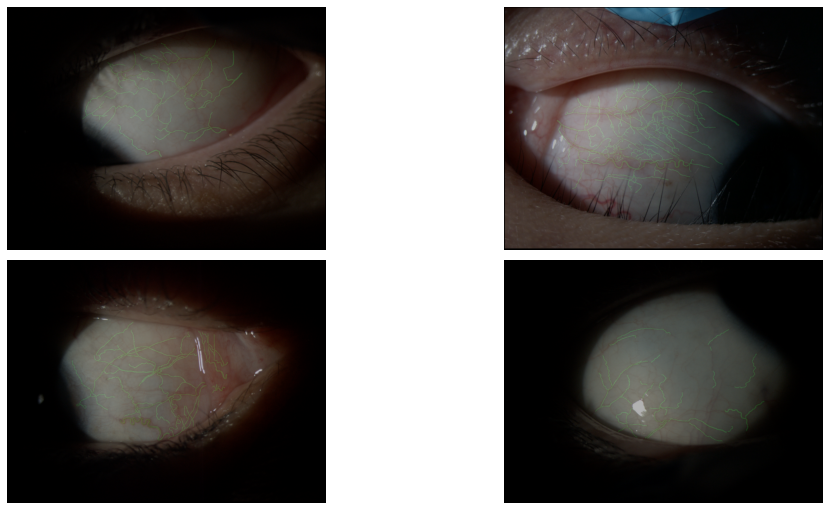

In [6]:
# as we can see, not all masks are perfect

fig, axs = plt.subplots(2, 2, figsize=(16, 8))


for i, sample in zip(range(4), dataset):
    transformed = transforms["test"](**sample)
    image, mask = transformed["image"], transformed["mask"]

    image_with_mask = draw_segmentation_masks(
        (image.cpu() * 255).type(torch.uint8), mask.type(torch.bool), alpha=0.3
    )
    image_with_mask = np.moveaxis(image_with_mask.cpu().numpy(), 0, -1)

    axs[i // 2, (i % 2)].imshow(image_with_mask)
    axs[i // 2, (i % 2)].axis("off")

    

fig.tight_layout()
fig.subplots_adjust(top=0.88)

In [7]:
# split dataset to train and validation parts
train_indices, test_indices = train_test_split(range(len(dataset)), test_size=0.1)

In [8]:
print(f"split on train and validation train/test : {len(train_indices)}/{len(test_indices)}")

split on train and validation train/test : 473/53


In [9]:

train_dataset = DatasetPart(dataset, train_indices, transform=transforms['train'])
valid_dataset = DatasetPart(dataset, test_indices, transform=transforms['test'])


In [10]:
train_loader = torch.utils.data.DataLoader(train_dataset, 1,
                                   num_workers=4,
                                   shuffle=True, drop_last=True)

valid_loader = torch.utils.data.DataLoader(valid_dataset, 1,
                                   num_workers=4,
                                   shuffle=True, drop_last=True)

## Utils

In [11]:
def plot_history(train_history, val_history, title="loss"):
    plt.figure()
    plt.title("{}".format(title))
    plt.plot(train_history, label="train", zorder=1)

    points = np.array(val_history)
    steps = list(
        range(0, len(train_history) + 1, int(len(train_history) / len(val_history)))
    )[1:]

    plt.scatter(
        steps, val_history, marker="+", s=180, c="orange", label="val", zorder=2
    )
    plt.xlabel("train steps")

    plt.legend(loc="best")
    plt.grid()

    plt.show()

# Model trainer class

In [12]:
from collections import defaultdict
from typing import Any, Callable, Dict, Iterator, List, Optional, Tuple


class UnetTrainer:
    """
    Model training class
    """

    def __init__(
        self,
        model: nn.Module,
        optimizer: torch.optim.Optimizer,
        criterion: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
        device: str,
        metric_functions: List[Tuple[str, Callable]] = [],
        epoch_number: int = 0,
        lr_scheduler: Optional[Any] = None,
    ):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.lr_scheduler = lr_scheduler

        self.device = device

        self.metric_functions = metric_functions

        self.epoch_number = epoch_number

    @torch.no_grad()
    def evaluate_batch(
        self, val_iterator: Iterator, eval_on_n_batches: int
    ) -> Optional[Dict[str, float]]:
        predictions = []
        targets = []

        losses = []

        for real_batch_number in range(eval_on_n_batches):
            try:
                batch = next(val_iterator)

                xs = batch["image"].to(self.device)
                ys_true = batch["mask"].to(self.device)
            except StopIteration:
                if real_batch_number == 0:
                    return None
                else:
                    break
            ys_pred = self.model.eval()(xs)
            loss = self.criterion(ys_pred, ys_true)

            losses.append(loss.item())

            predictions.append(ys_pred.cpu())
            targets.append(ys_true.cpu())

        predictions = torch.cat(predictions, dim=0)
        targets = torch.cat(targets, dim=0)

        metrics = {"loss": np.mean(losses)}

        for metric_name, metric_fn in self.metric_functions:
            metrics[metric_name] = metric_fn(predictions, targets).item()
        print(metrics)
        return metrics

    @torch.no_grad()
    def evaluate(self, val_loader, eval_on_n_batches: int = 1) -> Dict[str, float]:
        """
        Evaluate metrics for epoch
        """
        metrics_sum = defaultdict(float)
        num_batches = 0

        val_iterator = iter(val_loader)

        while True:
            batch_metrics = self.evaluate_batch(val_iterator, eval_on_n_batches)

            if batch_metrics is None:
                break

            for metric_name in batch_metrics:
                metrics_sum[metric_name] += batch_metrics[metric_name]

            num_batches += 1

        metrics = {}

        for metric_name in metrics_sum:
            metrics[metric_name] = metrics_sum[metric_name] / num_batches

        return metrics

    def fit_batch(
        self, train_iterator: Iterator, update_every_n_batches: int
    ) -> Optional[Dict[str, float]]:
        """
        train on one batch
        """

        self.optimizer.zero_grad()

        predictions = []
        targets = []

        losses = []

        for real_batch_number in range(update_every_n_batches):
            try:
                batch = next(train_iterator)

                xs = batch["image"].to(self.device)
                ys_true = batch["mask"].to(self.device)
            except StopIteration:
                if real_batch_number == 0:
                    return None
                else:
                    break

            ys_pred = self.model.train()(xs)
            loss = self.criterion(ys_pred, ys_true)

            (loss / update_every_n_batches).backward()

            losses.append(loss.item())

            predictions.append(ys_pred.cpu())
            targets.append(ys_true.cpu())

        self.optimizer.step()

        predictions = torch.cat(predictions, dim=0)
        targets = torch.cat(targets, dim=0)

        metrics = {"loss": np.mean(losses)}

        for metric_name, metric_fn in self.metric_functions:
            metrics[metric_name] = metric_fn(predictions, targets).item()

        return metrics

    def fit_epoch(
        self, train_loader, update_every_n_batches: int = 1
    ) -> Dict[str, float]:
        """
        Train on one epoch
        """

        metrics_sum = defaultdict(float)
        num_batches = 0

        train_iterator = iter(train_loader)

        while True:
            batch_metrics = self.fit_batch(train_iterator, update_every_n_batches)

            if batch_metrics is None:
                break

            for metric_name in batch_metrics:
                metrics_sum[metric_name] += batch_metrics[metric_name]

            num_batches += 1

        metrics = {}

        for metric_name in metrics_sum:
            metrics[metric_name] = metrics_sum[metric_name] / num_batches
        print(metrics)
        return metrics

    def fit(
        self,
        train_loader,
        num_epochs: int,
        val_loader=None,
        update_every_n_batches: int = 1,
    ) -> Dict[str, np.ndarray]:
        """
        training model and evaluating metrics by each epoch
        """

        summary = defaultdict(list)

        def save_metrics(metrics: Dict[str, float], postfix: str = "") -> None:
            nonlocal summary, self

            for metric in metrics:
                metric_name, metric_value = f"{metric}{postfix}", metrics[metric]

                summary[metric_name].append(metric_value)

        for _ in tqdm(
            range(num_epochs - self.epoch_number),
            initial=self.epoch_number,
            total=num_epochs,
        ):
            self.epoch_number += 1

            train_metrics = self.fit_epoch(train_loader, update_every_n_batches)

            with torch.no_grad():
                save_metrics(train_metrics, postfix="_train")

                if val_loader is not None:
                    test_metrics = self.evaluate(val_loader)
                    save_metrics(test_metrics, postfix="_test")

            if self.lr_scheduler is not None:
                self.lr_scheduler.step()

        summary = {metric: np.array(summary[metric]) for metric in summary}

        return summary

## Metrics

In [13]:
# F1-score
class SoftDice:
    def __init__(self, epsilon=1e-8):
        self.epsilon = epsilon

    def __call__(
        self,
        predictions: List[Dict[str, torch.Tensor]],
        targets: List[Dict[str, torch.Tensor]],
    ) -> torch.Tensor:
        numerator = torch.sum(2 * predictions * targets)
        denominator = torch.sum(predictions + targets)
        return numerator / (denominator + self.epsilon)


# recall
class Recall:
    def __init__(self, epsilon=1e-8, b=1):
        self.epsilon = epsilon
        self.a = b * b

    def __call__(
        self,
        predictions: List[Dict[str, torch.Tensor]],
        targets: List[Dict[str, torch.Tensor]],
    ) -> torch.Tensor:
        numerator = torch.sum(predictions * targets)
        denominator = torch.sum(targets)

        return numerator / (denominator + self.epsilon)


# accuracy
class Accuracy:
    def __init__(self, epsilon=1e-8, b=1):
        self.epsilon = epsilon
        self.a = b * b

    def __call__(self, predictions: list, targets: list) -> torch.Tensor:
        numerator = torch.sum(targets)
        denominator = torch.sum(predictions * targets)

        return numerator / (denominator + self.epsilon)


def make_metrics():
    soft_dice = SoftDice()
    recall = Recall()
    accuracy = Accuracy()

    def exp_dice(pred, target):
        return soft_dice(torch.exp(pred[:, 1:]), target[:, 1:])

    def acc(pred, target):
        return accuracy(torch.exp(pred[:, 1:]), target[:, 1:])

    def exp_recall(pred, target):
        return recall(torch.exp(pred[:, 1:]), target[:, 1:])

    return [
        ("exp_dice", exp_dice),
        ("accuracy", accuracy),
        ("recall", exp_recall),
    ]

# Model

In [14]:
# let use UNET from segmentation_models_pytorch with pretrained weights

model = smp.Unet("resnet50", activation="logsoftmax", classes=2).cuda()


def make_criterion():
    soft_dice = SoftDice()

    def exp_dice(pred, target):
        return 1 - soft_dice(torch.exp(pred[:, 1:]), target[:, 1:])

    return exp_dice


criterion = make_criterion()

In [15]:
from torchsummary import summary
with torch.no_grad():
    summary(model,input_size=(3,1248,1632))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 624, 816]           9,408
       BatchNorm2d-2         [-1, 64, 624, 816]             128
              ReLU-3         [-1, 64, 624, 816]               0
         MaxPool2d-4         [-1, 64, 312, 408]               0
            Conv2d-5         [-1, 64, 312, 408]           4,096
       BatchNorm2d-6         [-1, 64, 312, 408]             128
              ReLU-7         [-1, 64, 312, 408]               0
            Conv2d-8         [-1, 64, 312, 408]          36,864
       BatchNorm2d-9         [-1, 64, 312, 408]             128
             ReLU-10         [-1, 64, 312, 408]               0
           Conv2d-11        [-1, 256, 312, 408]          16,384
      BatchNorm2d-12        [-1, 256, 312, 408]             512
           Conv2d-13        [-1, 256, 312, 408]          16,384
      BatchNorm2d-14        [-1, 256, 3

In [17]:
optimizer = torch.optim.Adam(model.parameters(), 0.0001)

## Train model

In [18]:
# Обучаем модель
trainer = UnetTrainer(
    model, optimizer, criterion, "cuda", metric_functions=make_metrics()
)
summary = trainer.fit(train_loader, 15, val_loader=valid_loader)

  0%|          | 0/15 [00:00<?, ?it/s]

{'loss': 0.6136949892779989, 'exp_dice': 0.3863050150970513, 'accuracy': -13.875598544298215, 'recall': 0.7687476892142416}
{'loss': 0.37650853395462036, 'exp_dice': 0.6234914660453796, 'accuracy': -26.42101287841797, 'recall': 0.7571398615837097}
{'loss': 0.5265231132507324, 'exp_dice': 0.4734768867492676, 'accuracy': -20.604890823364258, 'recall': 0.820588231086731}
{'loss': 0.36917972564697266, 'exp_dice': 0.6308202743530273, 'accuracy': -9.720595359802246, 'recall': 0.540027379989624}
{'loss': 0.38079774379730225, 'exp_dice': 0.619202196598053, 'accuracy': -13.262450218200684, 'recall': 0.635840892791748}
{'loss': 0.5239434242248535, 'exp_dice': 0.47605663537979126, 'accuracy': -26.453235626220703, 'recall': 0.37797680497169495}
{'loss': 0.3340168595314026, 'exp_dice': 0.6659830808639526, 'accuracy': -56.481170654296875, 'recall': 0.7643492817878723}
{'loss': 0.5369695425033569, 'exp_dice': 0.4630303978919983, 'accuracy': -11.60759162902832, 'recall': 0.8288128972053528}
{'loss': 0

  7%|▋         | 1/15 [04:22<1:01:19, 262.84s/it]

{'loss': 0.39908987346713687, 'exp_dice': 0.6009101316758114, 'accuracy': -19.383706219856634, 'recall': 0.6770194399054408}
{'loss': 0.3738219141960144, 'exp_dice': 0.6261782050132751, 'accuracy': -11.716081619262695, 'recall': 0.5962063074111938}
{'loss': 0.3638281226158142, 'exp_dice': 0.6361719369888306, 'accuracy': -8.381155014038086, 'recall': 0.5184440016746521}
{'loss': 0.44152718782424927, 'exp_dice': 0.5584728121757507, 'accuracy': -18.019166946411133, 'recall': 0.4714365303516388}
{'loss': 0.4135410785675049, 'exp_dice': 0.5864588618278503, 'accuracy': -32.413543701171875, 'recall': 0.4957730770111084}
{'loss': 0.6299925446510315, 'exp_dice': 0.3700074255466461, 'accuracy': -8.037559509277344, 'recall': 0.4517582356929779}
{'loss': 0.3961837887763977, 'exp_dice': 0.6038162112236023, 'accuracy': -26.000545501708984, 'recall': 0.49012839794158936}
{'loss': 0.3449689745903015, 'exp_dice': 0.6550309658050537, 'accuracy': -20.43612289428711, 'recall': 0.6360577344894409}
{'loss':

 13%|█▎        | 2/15 [08:49<57:27, 265.19s/it]  

{'loss': 0.37756842689836756, 'exp_dice': 0.6224315758345621, 'accuracy': -17.7867761051428, 'recall': 0.6815091313806069}
{'loss': 0.29011452198028564, 'exp_dice': 0.7098855376243591, 'accuracy': -23.050668716430664, 'recall': 0.7057784199714661}
{'loss': 0.37479329109191895, 'exp_dice': 0.6252066493034363, 'accuracy': -15.385963439941406, 'recall': 0.7732161283493042}
{'loss': 0.3764481544494629, 'exp_dice': 0.6235518455505371, 'accuracy': -10.347244262695312, 'recall': 0.5708237290382385}
{'loss': 0.4213154911994934, 'exp_dice': 0.5786845684051514, 'accuracy': -17.376867294311523, 'recall': 0.5709930658340454}
{'loss': 0.37329304218292236, 'exp_dice': 0.6267069578170776, 'accuracy': -26.61018943786621, 'recall': 0.7636598944664001}
{'loss': 0.27205926179885864, 'exp_dice': 0.7279407382011414, 'accuracy': -19.255569458007812, 'recall': 0.7502185702323914}
{'loss': 0.40125125646591187, 'exp_dice': 0.5987487435340881, 'accuracy': -9.127914428710938, 'recall': 0.5385247468948364}
{'loss

 20%|██        | 3/15 [13:16<53:08, 265.71s/it]

{'loss': 0.3643474900193245, 'exp_dice': 0.6356525084763829, 'accuracy': -16.838048255468777, 'recall': 0.6853999434625749}
{'loss': 0.362426221370697, 'exp_dice': 0.637573778629303, 'accuracy': -18.647911071777344, 'recall': 0.5544114112854004}
{'loss': 0.2997761368751526, 'exp_dice': 0.7002238631248474, 'accuracy': -28.362913131713867, 'recall': 0.7325056195259094}
{'loss': 0.36378979682922363, 'exp_dice': 0.6362101435661316, 'accuracy': -6.637789726257324, 'recall': 0.5153909921646118}
{'loss': 0.26541614532470703, 'exp_dice': 0.7345837950706482, 'accuracy': -22.29734992980957, 'recall': 0.7182556986808777}
{'loss': 0.2816675901412964, 'exp_dice': 0.7183324098587036, 'accuracy': -25.932422637939453, 'recall': 0.7292987704277039}
{'loss': 0.4547843337059021, 'exp_dice': 0.5452155470848083, 'accuracy': -11.729857444763184, 'recall': 0.5665985345840454}
{'loss': 0.5277862548828125, 'exp_dice': 0.4722137153148651, 'accuracy': -7.377408504486084, 'recall': 0.9158311486244202}
{'loss': 0.

 27%|██▋       | 4/15 [17:35<48:15, 263.25s/it]

{'loss': 0.3575071096420288, 'exp_dice': 0.6424926519393921, 'accuracy': -22.785991668701172, 'recall': 0.7556416392326355}
{'loss': 0.3608928133770981, 'exp_dice': 0.639107188812396, 'accuracy': -15.849228917418273, 'recall': 0.6884228103492905}
{'loss': 0.2814685106277466, 'exp_dice': 0.7185314893722534, 'accuracy': -25.02121353149414, 'recall': 0.7249148488044739}
{'loss': 0.32542866468429565, 'exp_dice': 0.6745712757110596, 'accuracy': -13.105408668518066, 'recall': 0.6811107993125916}
{'loss': 0.422283411026001, 'exp_dice': 0.5777165293693542, 'accuracy': -7.565843105316162, 'recall': 0.4759528934955597}
{'loss': 0.3029136061668396, 'exp_dice': 0.6970863342285156, 'accuracy': -17.86550521850586, 'recall': 0.6130168437957764}
{'loss': 0.4947506785392761, 'exp_dice': 0.5052493214607239, 'accuracy': -16.01105308532715, 'recall': 0.35361769795417786}
{'loss': 0.3656027317047119, 'exp_dice': 0.6343972682952881, 'accuracy': -24.93049430847168, 'recall': 0.5476744174957275}
{'loss': 0.54

 33%|███▎      | 5/15 [22:03<44:09, 264.92s/it]

{'loss': 0.1965654492378235, 'exp_dice': 0.8034344911575317, 'accuracy': -56.45043182373047, 'recall': 0.793570876121521}
{'loss': 0.35354636751320095, 'exp_dice': 0.6464536375824921, 'accuracy': -15.224081177540107, 'recall': 0.6949141585990692}
{'loss': 0.30013442039489746, 'exp_dice': 0.6998655796051025, 'accuracy': -45.636474609375, 'recall': 0.9480825662612915}
{'loss': 0.3631754517555237, 'exp_dice': 0.6368244886398315, 'accuracy': -21.914690017700195, 'recall': 0.8479956388473511}
{'loss': 0.24612188339233398, 'exp_dice': 0.7538779973983765, 'accuracy': -24.03801727294922, 'recall': 0.7896924018859863}
{'loss': 0.2973055839538574, 'exp_dice': 0.7026944160461426, 'accuracy': -17.409669876098633, 'recall': 0.6769483685493469}
{'loss': 0.33825206756591797, 'exp_dice': 0.6617479920387268, 'accuracy': -22.146638870239258, 'recall': 0.7600978016853333}
{'loss': 0.39868777990341187, 'exp_dice': 0.6013122200965881, 'accuracy': -16.888023376464844, 'recall': 0.8440435528755188}
{'loss': 

 40%|████      | 6/15 [26:30<39:51, 265.69s/it]

{'loss': 0.7295280694961548, 'exp_dice': 0.2704719305038452, 'accuracy': -4.429677486419678, 'recall': 0.17391061782836914}
{'loss': 0.3501835155436655, 'exp_dice': 0.6498164873704094, 'accuracy': -14.675443505131922, 'recall': 0.694381682907111}
{'loss': 0.4048713445663452, 'exp_dice': 0.5951286554336548, 'accuracy': -6.691612243652344, 'recall': 0.4966330826282501}
{'loss': 0.7111203670501709, 'exp_dice': 0.2888796627521515, 'accuracy': -4.729468822479248, 'recall': 0.17135457694530487}
{'loss': 0.3418511748313904, 'exp_dice': 0.6581488251686096, 'accuracy': -13.569964408874512, 'recall': 0.6281300783157349}
{'loss': 0.3591083884239197, 'exp_dice': 0.6408916115760803, 'accuracy': -21.110137939453125, 'recall': 0.6039407253265381}
{'loss': 0.25868505239486694, 'exp_dice': 0.7413150072097778, 'accuracy': -17.86148452758789, 'recall': 0.7447095513343811}
{'loss': 0.41717517375946045, 'exp_dice': 0.5828248262405396, 'accuracy': -14.104605674743652, 'recall': 0.802151083946228}
{'loss': 0

 47%|████▋     | 7/15 [30:57<35:28, 266.00s/it]

{'loss': 0.3431490659713745, 'exp_dice': 0.6568509340286255, 'accuracy': -41.711891174316406, 'recall': 0.6904566884040833}
{'loss': 0.3495055022501794, 'exp_dice': 0.6504945044600686, 'accuracy': -13.953164945949208, 'recall': 0.6991951931937427}
{'loss': 0.4231796860694885, 'exp_dice': 0.5768203139305115, 'accuracy': -12.632643699645996, 'recall': 0.45651304721832275}
{'loss': 0.4001169800758362, 'exp_dice': 0.5998830199241638, 'accuracy': -13.111580848693848, 'recall': 0.5567017197608948}
{'loss': 0.26838237047195435, 'exp_dice': 0.7316175699234009, 'accuracy': -19.350460052490234, 'recall': 0.771320641040802}
{'loss': 0.3839470148086548, 'exp_dice': 0.6160529851913452, 'accuracy': -14.094006538391113, 'recall': 0.8492075204849243}
{'loss': 0.19510024785995483, 'exp_dice': 0.8048996925354004, 'accuracy': -166.0957489013672, 'recall': 0.8841533660888672}
{'loss': 0.40231066942214966, 'exp_dice': 0.5976893901824951, 'accuracy': -7.818361759185791, 'recall': 0.5140448212623596}
{'loss'

 53%|█████▎    | 8/15 [35:19<30:53, 264.75s/it]

{'loss': 0.3486278606519639, 'exp_dice': 0.651372143490748, 'accuracy': -13.741856584085218, 'recall': 0.6960099834799136}
{'loss': 0.7189313173294067, 'exp_dice': 0.28106868267059326, 'accuracy': -4.455092430114746, 'recall': 0.16592323780059814}
{'loss': 0.2873755097389221, 'exp_dice': 0.7126244902610779, 'accuracy': -21.74517822265625, 'recall': 0.7993349432945251}
{'loss': 0.7300420999526978, 'exp_dice': 0.26995790004730225, 'accuracy': -3.9858150482177734, 'recall': 0.1718210130929947}
{'loss': 0.33816033601760864, 'exp_dice': 0.6618396639823914, 'accuracy': -17.20287322998047, 'recall': 0.7614580392837524}
{'loss': 0.28470563888549805, 'exp_dice': 0.7152944207191467, 'accuracy': -22.699249267578125, 'recall': 0.732796847820282}
{'loss': 0.32992178201675415, 'exp_dice': 0.6700782179832458, 'accuracy': -7.390572547912598, 'recall': 0.6696069836616516}
{'loss': 0.24675971269607544, 'exp_dice': 0.7532402276992798, 'accuracy': -29.714340209960938, 'recall': 0.8419008851051331}
{'loss'

 60%|██████    | 9/15 [39:45<26:30, 265.15s/it]

{'loss': 0.3419499326709965, 'exp_dice': 0.6580500739604928, 'accuracy': -13.330702712621548, 'recall': 0.7013829361891519}
{'loss': 0.39178305864334106, 'exp_dice': 0.6082168221473694, 'accuracy': -16.359804153442383, 'recall': 0.6454015374183655}
{'loss': 0.3602970838546753, 'exp_dice': 0.6397029161453247, 'accuracy': -8.002840042114258, 'recall': 0.6275884509086609}
{'loss': 0.38904398679733276, 'exp_dice': 0.6109560132026672, 'accuracy': -4.915028095245361, 'recall': 0.47633635997772217}
{'loss': 0.2908608913421631, 'exp_dice': 0.7091391086578369, 'accuracy': -5.912204742431641, 'recall': 0.7180700898170471}
{'loss': 0.2839236855506897, 'exp_dice': 0.7160763740539551, 'accuracy': -16.941539764404297, 'recall': 0.7957580089569092}
{'loss': 0.43259352445602417, 'exp_dice': 0.5674065351486206, 'accuracy': -11.96548843383789, 'recall': 0.8876314759254456}
{'loss': 0.3426680564880371, 'exp_dice': 0.6573320031166077, 'accuracy': -15.907771110534668, 'recall': 0.8322795033454895}
{'loss':

 67%|██████▋   | 10/15 [44:13<22:09, 265.96s/it]

{'loss': 0.3404154669154774, 'exp_dice': 0.6595845331002743, 'accuracy': -12.81911220056562, 'recall': 0.704325913973389}
{'loss': 0.3330870270729065, 'exp_dice': 0.6669127941131592, 'accuracy': -9.831871032714844, 'recall': 0.9040970802307129}
{'loss': 0.387870192527771, 'exp_dice': 0.612129807472229, 'accuracy': -9.845669746398926, 'recall': 0.5225822925567627}
{'loss': 0.3438265323638916, 'exp_dice': 0.6561734676361084, 'accuracy': -8.015162467956543, 'recall': 0.8107680082321167}
{'loss': 0.36214184761047363, 'exp_dice': 0.6378580331802368, 'accuracy': -14.693626403808594, 'recall': 0.9161704182624817}
{'loss': 0.3194369077682495, 'exp_dice': 0.6805631518363953, 'accuracy': -12.790258407592773, 'recall': 0.7022491097450256}
{'loss': 0.42621171474456787, 'exp_dice': 0.5737882256507874, 'accuracy': -9.57649040222168, 'recall': 0.919900119304657}
{'loss': 0.2912634611129761, 'exp_dice': 0.7087365388870239, 'accuracy': -6.065717697143555, 'recall': 0.8202831745147705}
{'loss': 0.362603

 73%|███████▎  | 11/15 [48:38<17:43, 265.93s/it]

{'loss': 0.3374170929382518, 'exp_dice': 0.6625829113777294, 'accuracy': -12.450290409253466, 'recall': 0.7067387967703206}
{'loss': 0.38135063648223877, 'exp_dice': 0.6186493635177612, 'accuracy': -13.772191047668457, 'recall': 0.8283981680870056}
{'loss': 0.29560577869415283, 'exp_dice': 0.7043942213058472, 'accuracy': -12.761395454406738, 'recall': 0.6321598887443542}
{'loss': 0.28056102991104126, 'exp_dice': 0.7194389700889587, 'accuracy': -13.037615776062012, 'recall': 0.7127523422241211}
{'loss': 0.27688056230545044, 'exp_dice': 0.7231194376945496, 'accuracy': -40.67535400390625, 'recall': 0.9481334686279297}
{'loss': 0.43203675746917725, 'exp_dice': 0.5679632425308228, 'accuracy': -10.724730491638184, 'recall': 0.4703619182109833}
{'loss': 0.350838303565979, 'exp_dice': 0.6491617560386658, 'accuracy': -16.136037826538086, 'recall': 0.8476547002792358}
{'loss': 0.5953247547149658, 'exp_dice': 0.4046752452850342, 'accuracy': -11.732056617736816, 'recall': 0.26118558645248413}
{'lo

 80%|████████  | 12/15 [52:59<13:12, 264.31s/it]

{'loss': 0.33391241946633726, 'exp_dice': 0.6660875882283955, 'accuracy': -12.523990923456108, 'recall': 0.7071483664954944}
{'loss': 0.49231696128845215, 'exp_dice': 0.5076830387115479, 'accuracy': -6.610167026519775, 'recall': 0.36184754967689514}
{'loss': 0.2184046506881714, 'exp_dice': 0.7815952897071838, 'accuracy': -31.397212982177734, 'recall': 0.8017756938934326}
{'loss': 0.7019047737121582, 'exp_dice': 0.2980952262878418, 'accuracy': -3.9045631885528564, 'recall': 0.1839132010936737}
{'loss': 0.3555365204811096, 'exp_dice': 0.6444634795188904, 'accuracy': -15.230691909790039, 'recall': 0.7802371978759766}
{'loss': 0.28140151500701904, 'exp_dice': 0.718598484992981, 'accuracy': -16.577863693237305, 'recall': 0.8030233979225159}
{'loss': 0.3993643522262573, 'exp_dice': 0.6006355881690979, 'accuracy': -5.004742622375488, 'recall': 0.878786563873291}
{'loss': 0.37986087799072266, 'exp_dice': 0.6201391220092773, 'accuracy': -4.262594699859619, 'recall': 0.4920215904712677}
{'loss':

 87%|████████▋ | 13/15 [57:18<08:45, 262.81s/it]

{'loss': 0.33258789613937473, 'exp_dice': 0.6674121058059671, 'accuracy': -12.301994500150137, 'recall': 0.7080907410534442}
{'loss': 0.28283804655075073, 'exp_dice': 0.717162013053894, 'accuracy': -49.015464782714844, 'recall': 0.7440035343170166}
{'loss': 0.4851805567741394, 'exp_dice': 0.5148195028305054, 'accuracy': -5.743679046630859, 'recall': 0.8866066336631775}
{'loss': 0.2999061346054077, 'exp_dice': 0.7000937461853027, 'accuracy': -20.10428237915039, 'recall': 0.7074568867683411}
{'loss': 0.3282355070114136, 'exp_dice': 0.6717644929885864, 'accuracy': -10.287680625915527, 'recall': 0.6309568881988525}
{'loss': 0.39285218715667725, 'exp_dice': 0.6071478128433228, 'accuracy': -6.480374813079834, 'recall': 0.4833596348762512}
{'loss': 0.4675289988517761, 'exp_dice': 0.5324710607528687, 'accuracy': -10.137356758117676, 'recall': 0.8671929240226746}
{'loss': 0.3528236150741577, 'exp_dice': 0.6471763253211975, 'accuracy': -16.995670318603516, 'recall': 0.5338641405105591}
{'loss': 

 93%|█████████▎| 14/15 [1:01:49<04:25, 265.16s/it]

{'loss': 0.330690907751531, 'exp_dice': 0.6693090995730355, 'accuracy': -12.460430350918598, 'recall': 0.7108484795021708}
{'loss': 0.3795061707496643, 'exp_dice': 0.6204938292503357, 'accuracy': -5.260573863983154, 'recall': 0.8756487369537354}
{'loss': 0.3437320590019226, 'exp_dice': 0.6562680006027222, 'accuracy': -5.3218584060668945, 'recall': 0.6911929249763489}
{'loss': 0.3349425792694092, 'exp_dice': 0.6650574803352356, 'accuracy': -4.955464839935303, 'recall': 0.9308440685272217}
{'loss': 0.28479039669036865, 'exp_dice': 0.7152095437049866, 'accuracy': -15.861274719238281, 'recall': 0.8695108294487}
{'loss': 0.3789665699005127, 'exp_dice': 0.6210334300994873, 'accuracy': -10.033249855041504, 'recall': 0.644759476184845}
{'loss': 0.36048370599746704, 'exp_dice': 0.639516294002533, 'accuracy': -10.973592758178711, 'recall': 0.7847410440444946}
{'loss': 0.2944243550300598, 'exp_dice': 0.7055756449699402, 'accuracy': -10.56069564819336, 'recall': 0.8006132245063782}
{'loss': 0.3831

100%|██████████| 15/15 [1:06:13<00:00, 264.92s/it]

{'loss': 0.596045732498169, 'exp_dice': 0.4039543569087982, 'accuracy': -3.047086477279663, 'recall': 0.932989239692688}


In [19]:
torch.save(model.state_dict(), "./savings/last.pt")

In [25]:
# model.load_state_dict(torch.load("./savings/last.pt"))


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

## Check results

In [20]:
summary

{'loss_train': array([0.61369499, 0.39908987, 0.37756843, 0.36434749, 0.36089281,
        0.35354637, 0.35018352, 0.3495055 , 0.34862786, 0.34194993,
        0.34041547, 0.33741709, 0.33391242, 0.3325879 , 0.33069091]),
 'exp_dice_train': array([0.38630502, 0.60091013, 0.62243158, 0.63565251, 0.63910719,
        0.64645364, 0.64981649, 0.6504945 , 0.65137214, 0.65805007,
        0.65958453, 0.66258291, 0.66608759, 0.66741211, 0.6693091 ]),
 'accuracy_train': array([-13.87559854, -19.38370622, -17.78677611, -16.83804826,
        -15.84922892, -15.22408118, -14.67544351, -13.95316495,
        -13.74185658, -13.33070271, -12.8191122 , -12.45029041,
        -12.52399092, -12.3019945 , -12.46043035]),
 'recall_train': array([0.76874769, 0.67701944, 0.68150913, 0.68539994, 0.68842281,
        0.69491416, 0.69438168, 0.69919519, 0.69600998, 0.70138294,
        0.70432591, 0.7067388 , 0.70714837, 0.70809074, 0.71084848]),
 'loss_test': array([0.43624517, 0.41147669, 0.3937061 , 0.39368522, 0.3

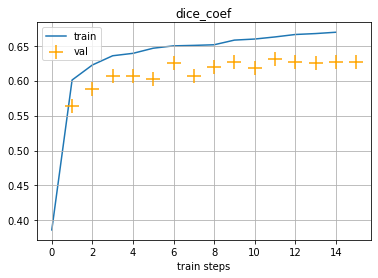

In [25]:
#  exp_dice_coef
plot_history(summary["exp_dice_train"], summary["exp_dice_test"], title='dice_coef')

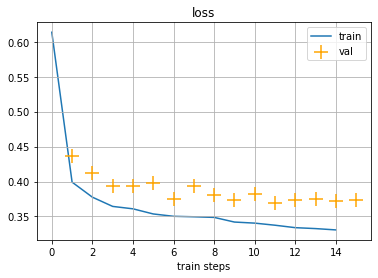

In [22]:
# loss
plot_history(summary["loss_train"], summary["loss_test"])

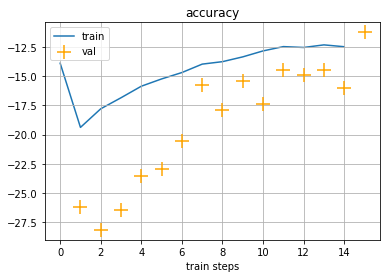

In [23]:
# accuracy
plot_history(summary["accuracy_train"], summary["accuracy_test"], "accuracy")

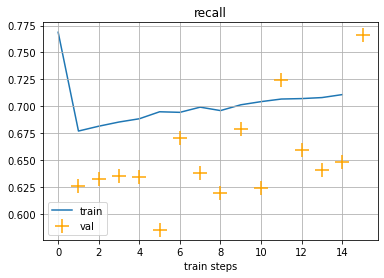

In [24]:
# recall
plot_history(summary["recall_train"], summary["recall_test"], "recall")

(1248, 1632, 3)
(1248, 1632, 3)
(1248, 1632, 3)
(1248, 1632, 3)


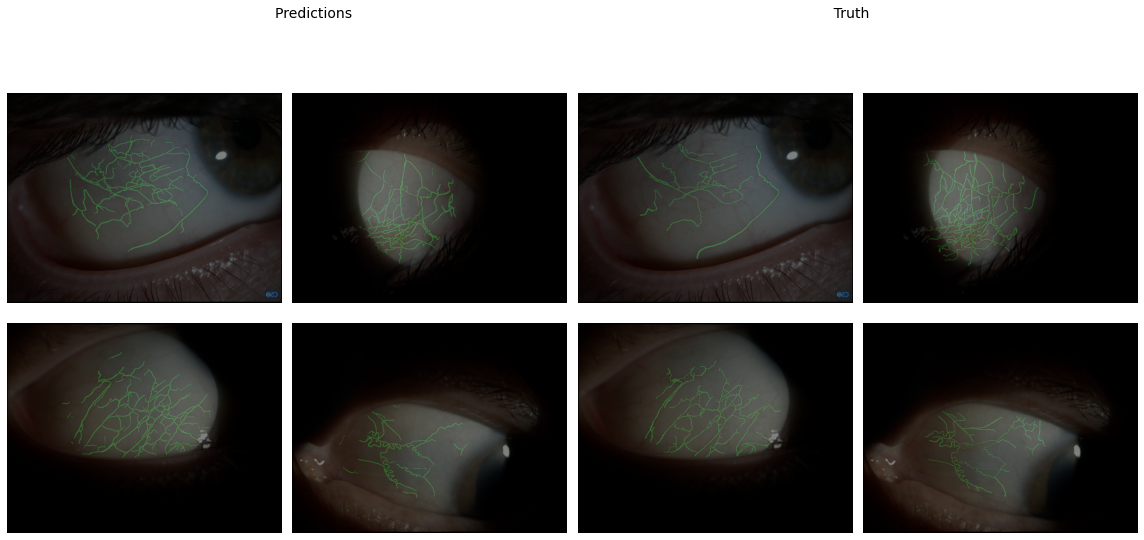

In [29]:
# let check train images with predicted masks before final tranformations

fig, axs = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle(f'Predictions {" "*105} Truth', fontsize=14)
model.eval()
with torch.no_grad():
    for i, sample in zip(range(4), valid_dataset):
        image = sample["image"].to("cuda")
        true_mask = sample["mask"].to("cuda")

        prediction = model.eval()(image.unsqueeze(dim=0))

        image = (image.cpu() * 255).type(torch.uint8)
        pred_ask = (torch.exp(prediction[0]) > 0.5).cpu()

        image_with_mask = draw_segmentation_masks(image, pred_ask, alpha=0.5)
        image_with_mask = np.moveaxis(image_with_mask.cpu().numpy(), 0, -1)
        print(image_with_mask.shape)
        axs[i // 2, (i % 2)].imshow(image_with_mask)
        axs[i // 2, (i % 2)].axis("off")

        image_with_mask = draw_segmentation_masks(image, true_mask.type(torch.bool), alpha=0.5)
        image_with_mask = np.moveaxis(image_with_mask.cpu().numpy(), 0, -1)
        axs[i // 2, (i % 2) + 2].imshow(image_with_mask)
        axs[i // 2, (i % 2) + 2].axis("off")


fig.tight_layout()
fig.subplots_adjust(top=0.88)

# Predictions

create dataset with tests images, that masks we would predict

In [30]:
test_dataset = EyeDataset(
    "/home/prop/Cifrovoi_proriv/test_dataset_mc/eye_test", test=True
)

In [31]:
test_loader = torch.utils.data.DataLoader(
    test_dataset, 1, num_workers=4, shuffle=False, drop_last=True
)

In [32]:
for msg in test_dataset.make_report():
    print(msg)

Found 301 images
Found 301 images without masks


In [33]:
# predict every test image
model.eval()
pred_list = []
with torch.no_grad():

    for file in range(len(test_dataset)):
        try:
            transformed = transforms["test_test"](image=test_dataset[file]["image"])
            pred = model(transformed["image"].to("cuda").unsqueeze(dim=0))
            pred_list.append(pred.to("cpu"))
        except Exception as e:
            print(file, e)

## Final image trainsformations

for every prediction we draw countours. All countours we filter by the size of area. The smallest countours we draw by black color to erase artefacts and leave only capillaris

In [34]:
thr_length = 300

In [35]:
for i in range(len(pred_list)):
    test_pred = pred_list[i]
    pred_ask = (torch.exp(test_pred[0][1]) > 0.5).cpu()
    name = test_dataset[i]["name"]
    # if name in sampl:

    tt = np.array(pred_ask)
    tt = tt.astype("uint8")

    # blur image to reduce the noise in the image while thresholding. #This smoothens the sharp edges in the image.
    blur = cv2.blur(tt, (10, 10))
    # Apply thresholding to the image
    ret, thresh = cv2.threshold(blur, 1, 255, cv2.THRESH_OTSU)
    # find the contours in the image
    contours, heirarchy = cv2.findContours(
        thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE
    )
    # filter small countours    
    conours_0 = []
    for cont in contours:
        if cv2.contourArea(cont) < thr_length:
            conours_0.append(cont)

    # Create a mask image that contains the contour filled in
    cv2.drawContours(tt, conours_0, -1, color=0, thickness=-1)
    
    #  crop image to initate shape    
    tt = (tt.astype("int") * 255)[8:1240, 4:1628]
    # write image to disk
    cv2.imwrite(f"./predictions/16/{name}.png", tt)

torch.Size([2, 1248, 1632])


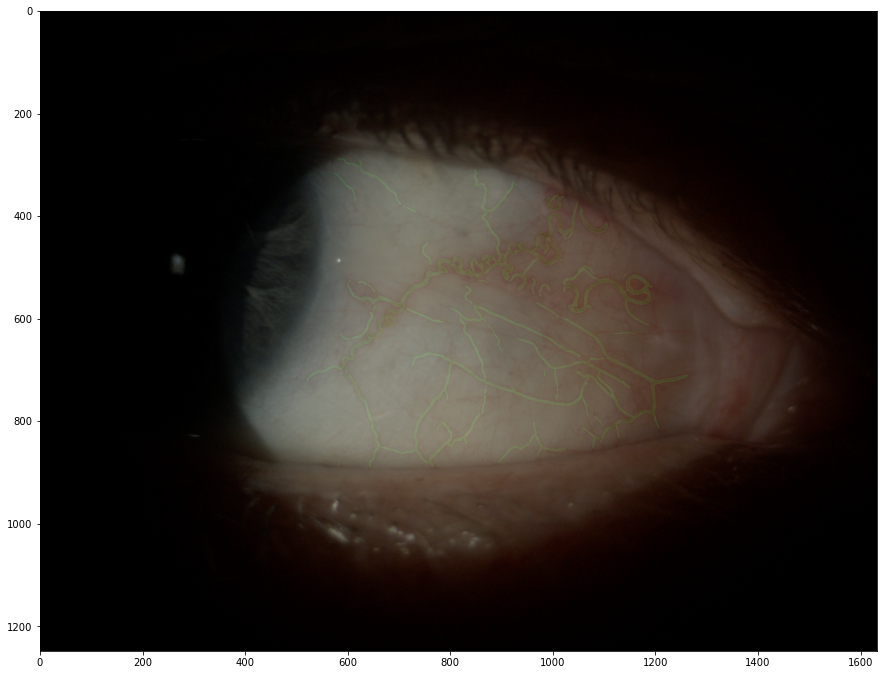

In [25]:
# let see predictions on test image
transformed = transforms["test_test"](image=test_dataset[3]["image"])
image = transformed["image"].to("cuda")

image = (image.cpu() * 255).type(torch.uint8)
pred_ask = (torch.exp(test_pred[0]) > 0.1).cpu()

image_with_mask = draw_segmentation_masks(image, pred_ask, alpha=0.2)
image_with_mask = np.moveaxis(image_with_mask.cpu().numpy(), 0, -1)

plt.figure(figsize=(15, 20))
plt.imshow(image_with_mask)
plt.show()